# Amide Position Modelling

In [1]:
import numpy as np
import array as arr
from mayavi import mlab
import matplotlib.pyplot as plt

def get_incl(x, y, z):
    # Gives inclination angle given cartesian coordinates x, y, z
    xyd = np.sqrt((x**2) + (y**2))
    return np.arctan2(xyd, z)                     

def get_az(x, y):
    # Gives azimuth angle given cartesian coordinates x, y 
    az = np.arctan2(y, x)
    az[az < 0] += 2*np.pi
    return az

def plot_axes(n, c=(0., 0., 0.)):    
    # n is number of axes wanted, c describes colour of axes
    o = np.zeros(2)
    a = np.array([0., n])
    mlab.plot3d(a, o, o, tube_radius=None, color=c)
    mlab.plot3d(o, a, o, tube_radius=None, color=c)
    mlab.plot3d(o, o, a, tube_radius=None, color=c)
    return

def polar_to_cart_elev(r, elev, az):
    # converts polar coordinates r, elev, az into cartesian coordinates x, y, z
    x = r * np.cos(elev) * np.cos(az)
    y = r * np.cos(elev) * np.sin(az)
    z = r * np.sin(elev)
    return x, y, z

## Spherical Plotting

Golden Spiral Method:

In [2]:
from numpy import pi, cos, sin, arccos, arange

def spherical_grid(n=500):
    # n is the number of points created on the spherical grid
    indices = arange(0, n, dtype=float) + 0.5
    phi = arccos(1 - 2*indices/n)
    theta = pi * (1 + 5**0.5) * indices
    x, y, z = cos(theta) * sin(phi), sin(theta) * sin(phi), cos(phi)
    return x, y, z

In [3]:
# run this cell to visualise your grid
fig = mlab.figure(bgcolor=(1., 1., 1.))
x, y, z = spherical_grid(n=100)
mlab.points3d(x, y, z, scale_mode='none')
plot_axes(1.5)
mlab.orientation_axes()
mlab.show()

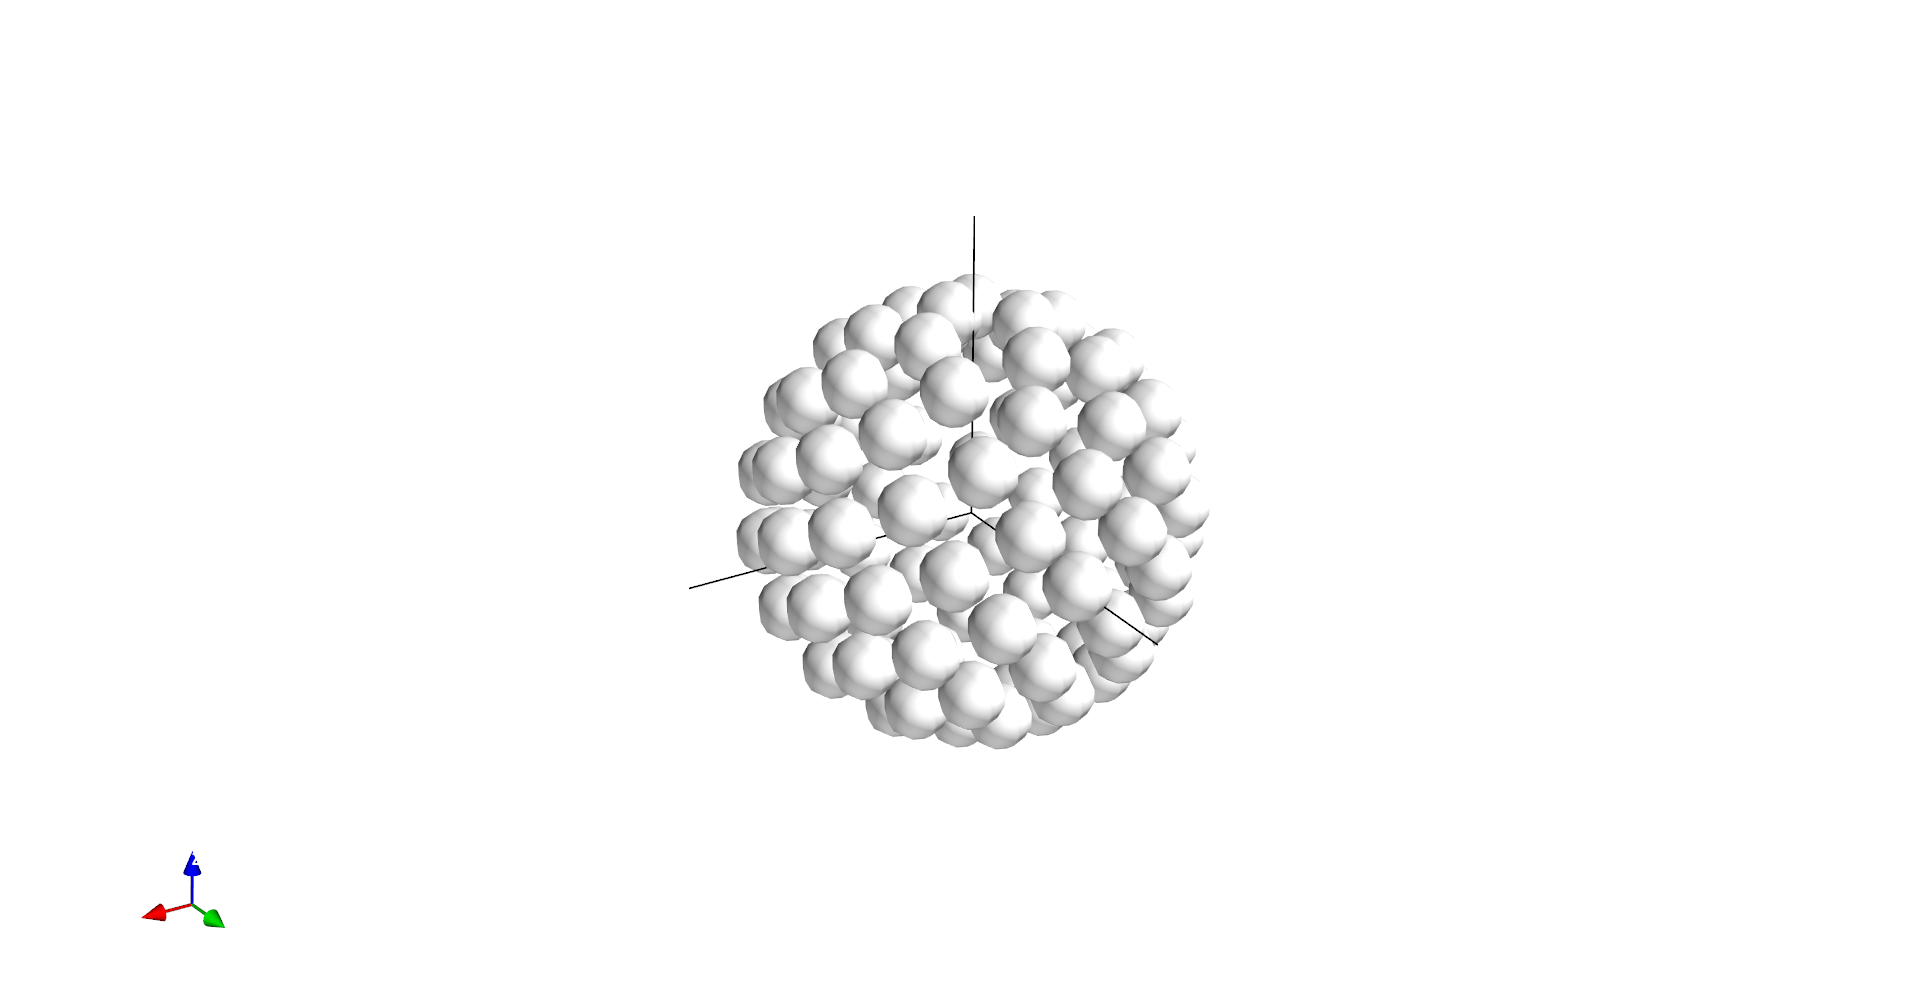

## Amide Modelling

In [4]:
def get_amide_circumference(elev, az, n, psi, r=1):   
    # generating n points at psi deg on sphere surface from e, a point (psi is the fixed angle between the amide hydrogens)
    e = np.pi/2 - elev
    a = -(az + np.pi)
    
    # producing n random points on circumference at psi deg from the north pole (0,0,1)
    rdm = np.random.rand()
    new_az = np.linspace(rdm, (rdm + 1), n) * 2 * np.pi
    new_elev = (np.pi / 2. - psi * np.pi / 180.) * np.ones(n)
    
    # find cartesian coordinates of these n points - r is the radius of sphere (N-H distance)
    x, y, z = polar_to_cart_elev(r, new_elev, new_az)
    
    # rotate points back to original by putting north pole back to point r, elev, az
    sin, cos = np.sin, np.cos
    xp = cos(e)*cos(a)*x + sin(a)*y - sin(e)*cos(a)*z
    yp = -sin(a)*cos(e)*x + cos(a)*y + sin(a)*sin(e)*z
    zp = sin(e)*x + cos(e)*z
    return xp, yp, zp

x, y, z = spherical_grid(n=100)

pt_elev = np.pi / 2. - get_incl(x, y, z)
pt_az = get_az(x, y)

In [6]:
def plot_each_amide(n, a, amide_angle):
    # n = number of random points on circumference
    # a = index of point on spherical grid, 
    # amide_angle = (psi) angle in deg to circumference
    xp, yp, zp = get_amide_circumference(pt_elev[a], pt_az[a], n, amide_angle)
    x0, y0, z0 = polar_to_cart_elev(1, pt_elev[a], pt_az[a])

    mlab.figure(bgcolor=(1., 1., 1.))
    mlab.points3d(x, y, z, scale_factor=0.1, scale_mode='none')
    mlab.points3d(x0, y0, z0, color=(1., 0., 0.), scale_factor=0.1)
    mlab.points3d(xp, yp, zp, color=(0., 0., 1.), scale_factor=0.1)
    plot_axes(1.5)
    mlab.orientation_axes()
    mlab.show()
    
#plot_each_amide(8, 50, 101.56)

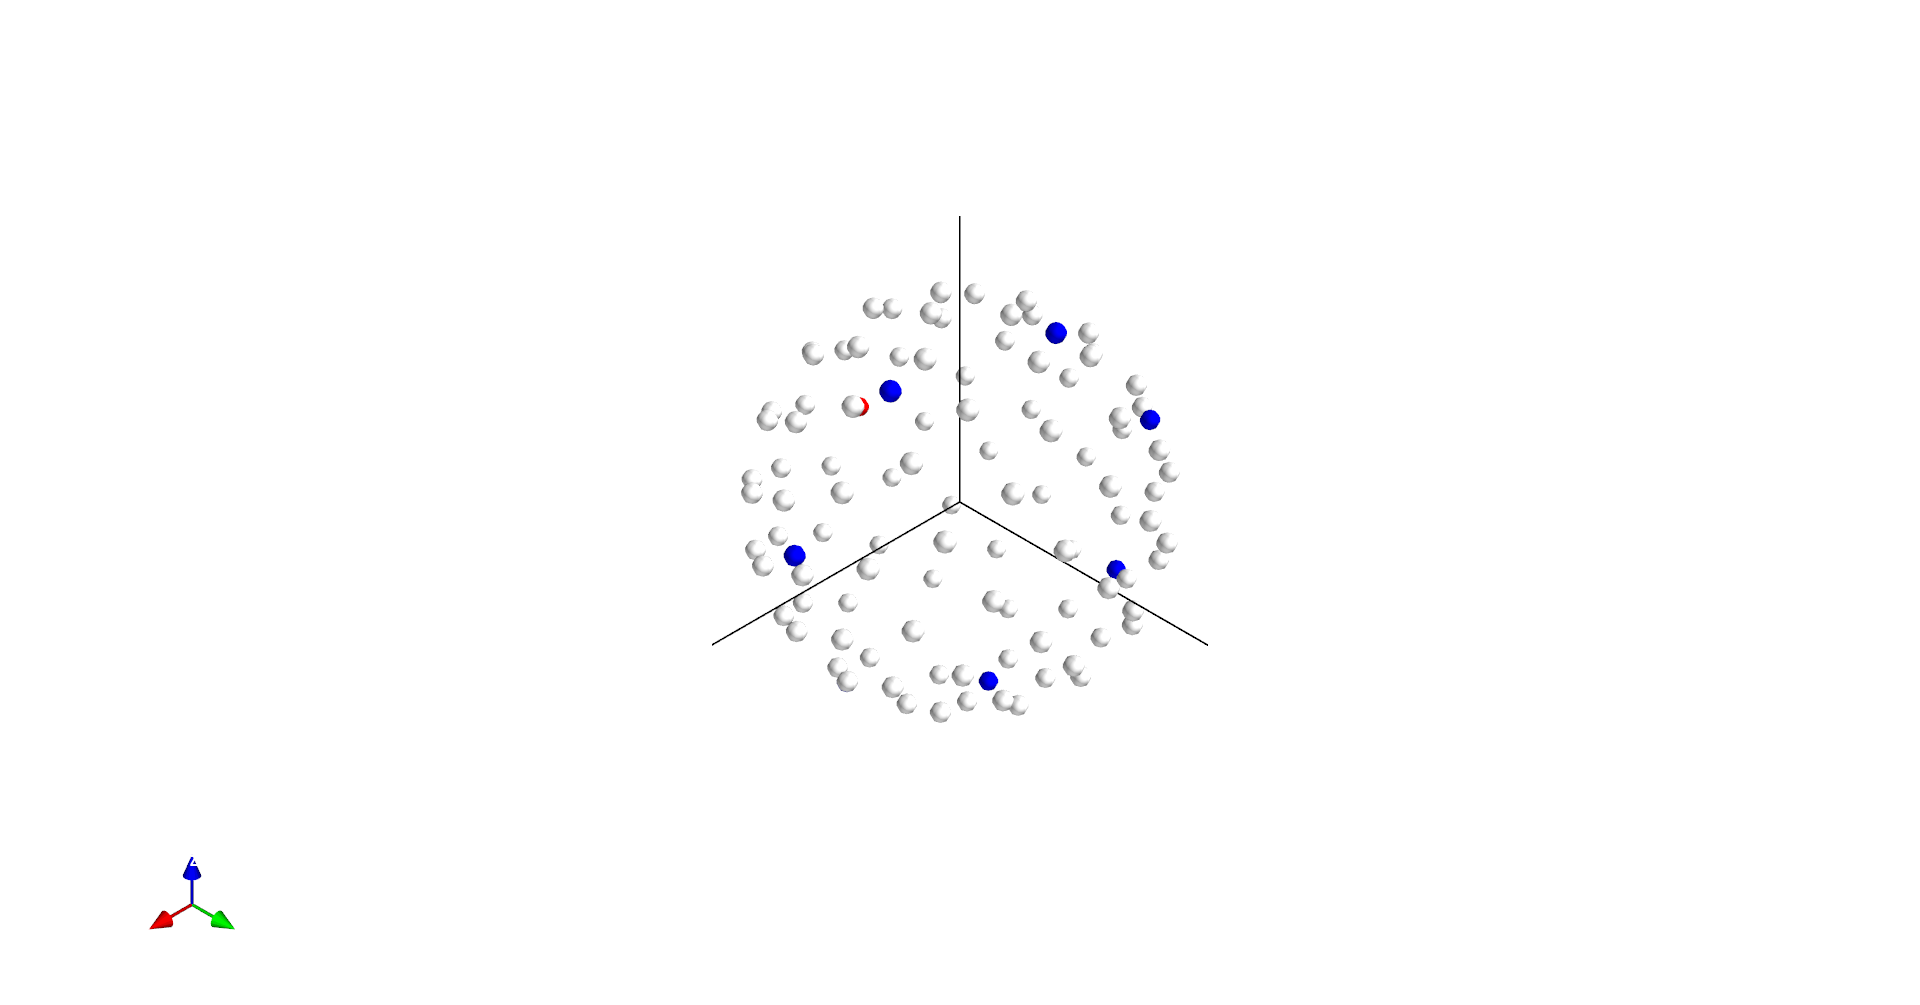

## Iterating through all positions:

In [10]:
def iterate(n_grid=100, n_circ=8, amide_angle=101.5643):
    # creating arrays of coordinates corresponding to the positions of each hydrogen in the amide
    x1 = arr.array('f', [])
    y1 = arr.array('f', [])
    z1 = arr.array('f', [])
    x2 = arr.array('f', [])
    y2 = arr.array('f', [])
    z2 = arr.array('f', [])
    
    x, y, z = spherical_grid(n_grid)
    pt_elev = np.pi / 2. - get_incl(x, y, z)
    pt_az = get_az(x, y)
    for i in range(len(x)):
        xp, yp, zp = get_amide_circumference(pt_elev[i], pt_az[i], n_circ, amide_angle, r=1.03149)
        x0, y0, z0 = polar_to_cart_elev(1.03149, pt_elev[i], pt_az[i])                 # r in angstrom

        x2.extend(xp[0:7]) # xp has 8 values in it - the first and last are duplicated
        y2.extend(yp[0:7])
        z2.extend(zp[0:7])
        x1.extend([x0 for a in range(7)])
        y1.extend([y0 for a in range(7)])
        z1.extend([z0 for a in range(7)])
        
    return x1, y1, z1, x2, y2, z2

Coordinates centered around the nitrogen atom:

In [11]:
x1, y1, z1, x2, y2, z2 = iterate(n_grid=100, n_circ=8, amide_angle=101.5643)

In [13]:
# check it looks ok
mlab.figure(bgcolor=(1., 1., 1.))
mlab.points3d(x1[7], y1[7], z1[7], scale_factor=0.1, scale_mode='none')
mlab.points3d(x2[7:14], y2[7:14], z2[7:14], color=(1., 0., 0.), scale_factor=0.1)
plot_axes(1.5)
mlab.orientation_axes()
#mlab.show()

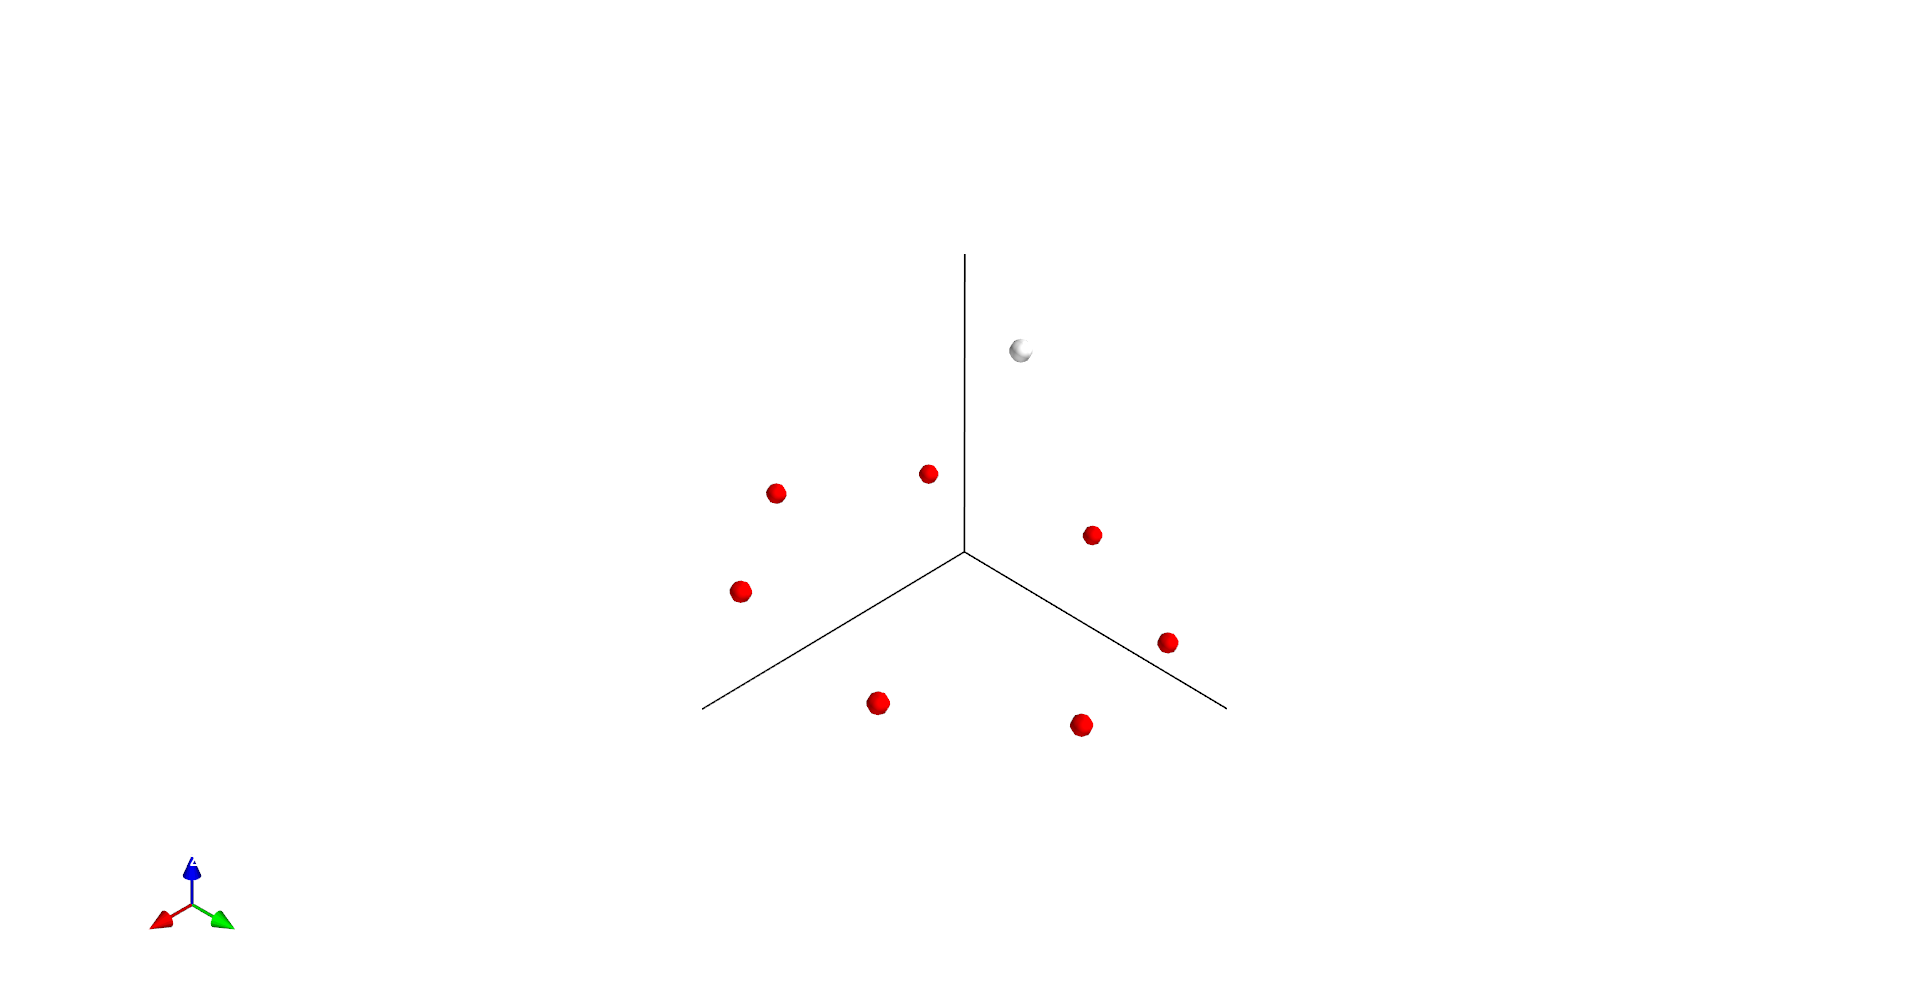

## Creating each cif file:

In [14]:
from pymatgen.io.cif import CifParser, CifWriter
fname = 'C:\\Users\\Path\\NaNH2.cif'
cif = CifParser(fname)

In [15]:
structure = cif.get_structures()[0]

In [16]:
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
rstructure = SpacegroupAnalyzer(structure).get_refined_structure()
rstructure

Structure Summary
Lattice
    abc : 8.34421466 9.00508907 10.46958114
 angles : 90.0 90.0 90.0
 volume : 786.6884752479067
      A : 8.34421466 0.0 0.0
      B : 0.0 9.00508907 0.0
      C : 0.0 0.0 10.46958114
    pbc : True True True
PeriodicSite: Na (6.2582, 6.7538, 6.3397) [0.7500, 0.7500, 0.6055]
PeriodicSite: Na (6.2582, 6.7538, 9.3647) [0.7500, 0.7500, 0.8945]
PeriodicSite: Na (4.1721, 0.0000, 8.9571) [0.5000, 0.0000, 0.8555]
PeriodicSite: Na (0.0000, 0.0000, 6.7473) [0.0000, 0.0000, 0.6445]
PeriodicSite: Na (6.2582, 2.2513, 1.1049) [0.7500, 0.2500, 0.1055]
PeriodicSite: Na (6.2582, 2.2513, 4.1299) [0.7500, 0.2500, 0.3945]
PeriodicSite: Na (4.1721, 4.5025, 3.7223) [0.5000, 0.5000, 0.3555]
PeriodicSite: Na (0.0000, 4.5025, 1.5125) [0.0000, 0.5000, 0.1445]
PeriodicSite: Na (2.0861, 6.7538, 1.1049) [0.2500, 0.7500, 0.1055]
PeriodicSite: Na (2.0861, 6.7538, 4.1299) [0.2500, 0.7500, 0.3945]
PeriodicSite: Na (0.0000, 0.0000, 3.7223) [0.0000, 0.0000, 0.3555]
PeriodicSite: Na (4.1721, 0

In [20]:
def rstruc_coords(number_Na=16, number_H=32, number_N=16):
    Na_x = arr.array('f', [])
    H_x = arr.array('f', [])
    N_x = arr.array('f', [])
    
    Na_y = arr.array('f', [])
    H_y = arr.array('f', [])
    N_y = arr.array('f', [])
    
    Na_z = arr.array('f', [])
    H_z = arr.array('f', [])
    N_z = arr.array('f', [])
    
    for i in range(0, number_Na):
        Na_x.append(rstructure.sites[i].coords[0])
    for j in range(number_Na, (number_Na+number_H+1)):
        H_x.append(rstructure.sites[j].coords[0])
    for k in range((number_Na+number_H+1), (number_Na+number_H+number_N)):
        N_x.append(rstructure.sites[k].coords[0])
        
    for i in range(0, number_Na):
        Na_y.append(rstructure.sites[i].coords[1])
    for j in range(number_Na, (number_Na+number_H+1)):
        H_y.append(rstructure.sites[j].coords[1])
    for k in range((number_Na+number_H+1), (number_Na+number_H+number_N)):
        N_y.append(rstructure.sites[k].coords[1])
        
    for i in range(0, number_Na):
        Na_z.append(rstructure.sites[i].coords[2])
    for j in range(number_Na, (number_Na+number_H+1)):
        H_z.append(rstructure.sites[j].coords[2])
    for k in range((number_Na+number_H+1), (number_Na+number_H+number_N)):
        N_z.append(rstructure.sites[k].coords[2])
        
    return Na_x, H_x, N_x, Na_y, H_y, N_y, Na_z, H_z, N_z
        
Na_x, H_x, N_x, Na_y, H_y, N_y, Na_z, H_z, N_z = rstruc_coords()

In [21]:
# visualises the unit cell
mlab.figure(bgcolor=(1., 1., 1.))
mlab.points3d(Na_x, Na_y, Na_z, color=(0., 1., 0.), scale_factor=0.8)
mlab.points3d(H_x, H_y, H_z, color=(1., 0., 0.), scale_factor=0.3)
mlab.points3d(N_x, N_y, N_z, color=(0., 0., 1.), scale_factor=0.6)

#mlab.points3d(3.6724, 2.5904, 1.8938, color=(0., 1., 1.), scale_factor=0.6) # uncomment to highlight chosen hydrogen
#mlab.points3d(3.6724, 1.9122, 3.3410, color=(0., 1., 1.), scale_factor=0.6) # uncomment to highlight chosen hydrogen
plot_axes(1.5)

mlab.outline(extent = [0, 8.34421466, 0, 9.00508907, 0, 10.46958114], color = (0.,0.,0.), opacity = 0.4)
#mlab.show()

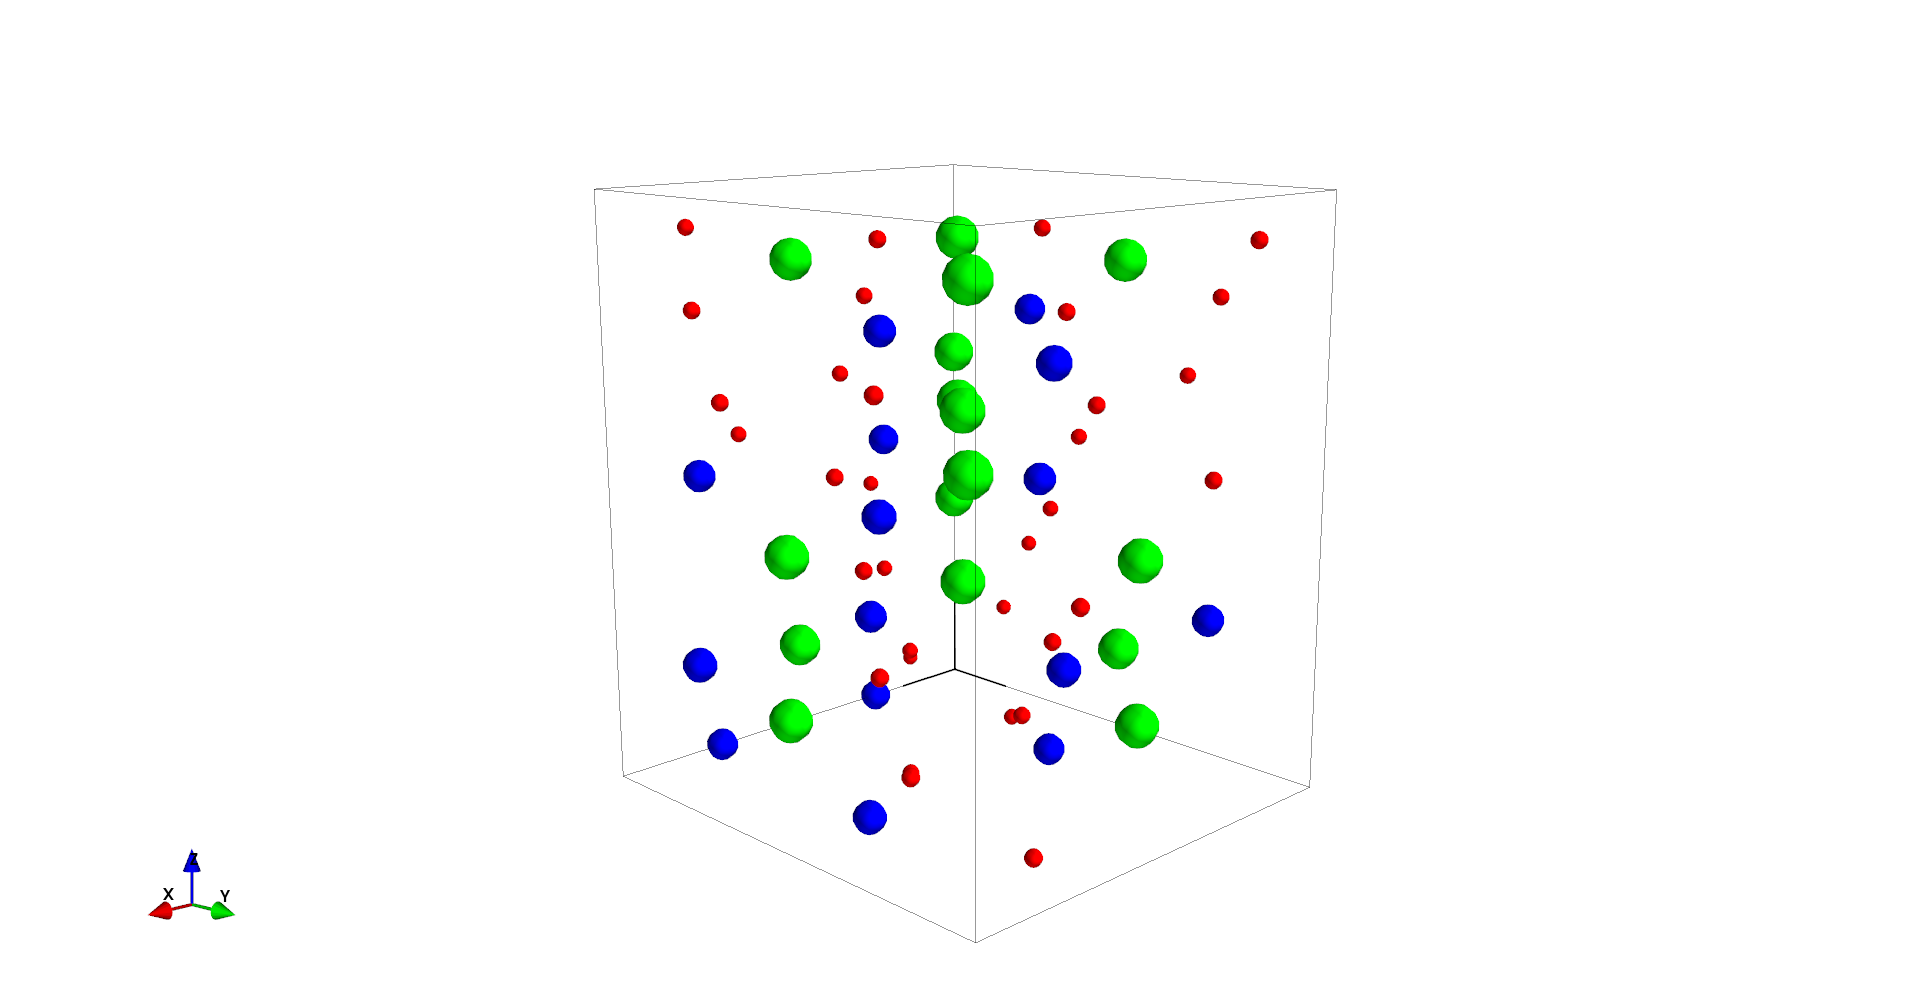

Amide Chosen: 
- H (3.6724, 2.5904, 1.8938) [0.4401, 0.2877, 0.1809] - index 33 - H 18 in .castep
- H (3.6724, 1.9122, 3.3410) [0.4401, 0.2123, 0.3191] - index 34 - H 19 in .castep
- N (4.3246, 2.2513, 2.6174) [0.5183, 0.2500, 0.2500] - index 53 - N 6 in .castep

In [16]:
def create_cif(n_grid=100, n_circ=8, amide_angle=101.5643):
    # creates new cif from the imported one by shifting the chosen amide's hydrogen to each in the array of orientations produced with the spherical grid
    amide_centre = np.array([4.3246, 2.2513, 2.6174])
    x1, y1, z1, x2, y2, z2 = iterate(n_grid, n_circ, amide_angle)
    
    x1c = x1 + amide_centre[0]
    y1c = y1 + amide_centre[1]
    z1c = z1 + amide_centre[2]
    
    x2c = x2 + amide_centre[0]
    y2c = y2 + amide_centre[1]
    z2c = z2 + amide_centre[2]
    
    for i in range(0, len(x1c+1)):
        new_struc = rstructure.copy()
        new_struc.sites[33].coords = [x1c[i], y1c[i], z1c[i]]
        new_struc.sites[34].coords = [x2c[i], y2c[i], z2c[i]]
    
        w = CifWriter(new_struc)
        file = 'C:\\Users\\Path\\' + str(i+1) + '.cif'
        w.write_file(file)

In [17]:
#create_cif()